# Assignment: week 5
### Objectives
The objectives of this assignment are:

1. to learn about residual connections and layer normalization, and their implementation
2. to assemble a model using these components (simplified Transformer encoder block)

In [ ]:
import keras
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.layers import Input, Dense, GlobalAveragePooling1D,Add, LayerNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping


### Getting imdb data


In [16]:
max_features = 10000
max_len = 250

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = keras.utils.pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = keras.utils.pad_sequences(x_test, maxlen=max_len, padding='post')

In [3]:
word_to_index = imdb.get_word_index()
index_to_word = dict((value, key) for (key, value) in word_to_index.items())

example_review = " ".join(index_to_word.get(i - 3, "?") for i in x_train[0])
print(example_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

### Token and Position Embedding Layer


In [4]:
from keras.layers import Layer, Embedding


class TokenAndPositionEmbedding(Layer):
    def __init__(self, seq_len, vocab_size, emb_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=emb_dim)
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=emb_dim)

    def call(self, x_input):
        seq_len = keras.ops.shape(x_input)[-1]
        positions = keras.ops.arange(start=0, stop=seq_len, step=1)
        positions = self.pos_emb(positions)
        x_input = self.token_emb(x_input)
        return x_input + positions

### Creating model

In [151]:
from keras.layers import MultiHeadAttention
from keras.layers import Dropout

embed_dim = 32
num_heads = 3
key_dim = embed_dim // num_heads

inputs = Input(shape=(max_len,))
x_in = TokenAndPositionEmbedding(max_len, max_features, embed_dim)(inputs)

# Attention layer
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x_in, x_in, x_in)
attention_output = Dropout(0.5)(attention_output)
x2 = Add()([x_in, attention_output])
x2 = LayerNormalization()(x2)

# Feedforward
ff = Dense(32, activation='relu')(x2)
ff = Dropout(0.1)(ff)
ff = Dense(embed_dim)(ff)
x3 = Add()([x2, ff])
x3 = LayerNormalization()(x3)

# Pooling + Output
pooled = GlobalAveragePooling1D()(x3)
outputs = Dense(1, activation='sigmoid')(pooled)

att_model = Model(inputs=inputs, outputs=outputs)

att_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

att_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 250, 32)   │    328,000 │ input_layer_30[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 32)   │      3,962 │ token_and_positi… │
│ (MultiHeadAttentio… │                   │            │ token_and_positi… │
│                     │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 250, 32)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 250, 32)   │          0 │ token_and_positi… │
│                     │                   │            │ dropout_70[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 32)   │         64 │ add_55[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 250, 32)   │      1,056 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 250, 32)   │          0 │ dense_81[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 250, 32)   │      1,056 │ dropout_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 250, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_82[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 32)   │         64 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 1)         │         33 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 334,235 (1.28 MB)

 Trainable params: 334,235 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

### Training model

In [152]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2,verbose= 1,restore_best_weights=True)

history = att_model.fit(x_train, y_train,validation_split=0.2,callbacks=[early_stopping], verbose=2, epochs=5, batch_size=64)

Epoch 1/5
313/313 - 13s - 41ms/step - accuracy: 0.7793 - loss: 0.4564 - val_accuracy: 0.8812 - val_loss: 0.2878
Epoch 2/5
313/313 - 12s - 38ms/step - accuracy: 0.9112 - loss: 0.2224 - val_accuracy: 0.8882 - val_loss: 0.2713
Epoch 3/5
313/313 - 12s - 39ms/step - accuracy: 0.9428 - loss: 0.1527 - val_accuracy: 0.8780 - val_loss: 0.3170
Epoch 4/5
313/313 - 12s - 38ms/step - accuracy: 0.9620 - loss: 0.1088 - val_accuracy: 0.8694 - val_loss: 0.3833
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


### Evaluation

I tried lots of different values, without modifying the given structure and could not prevent model for overfitting. Luckily early stopping helps for retrieving the best possible model.

In [153]:
loss, accuracy = att_model.evaluate(x_test, y_test)

print(f'Test accuracy = {accuracy:.4f}')
print(f'Test loss = {loss:.4f}')


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8813 - loss: 0.2821
Test accuracy = 0.8813
Test loss = 0.2821


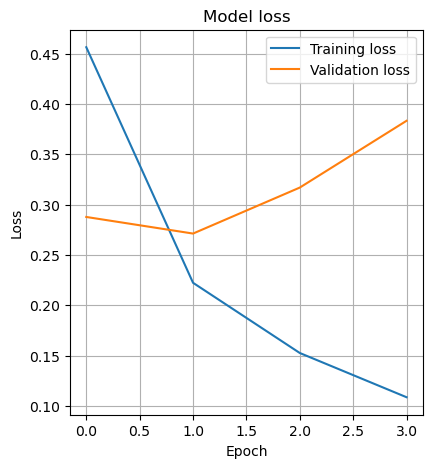

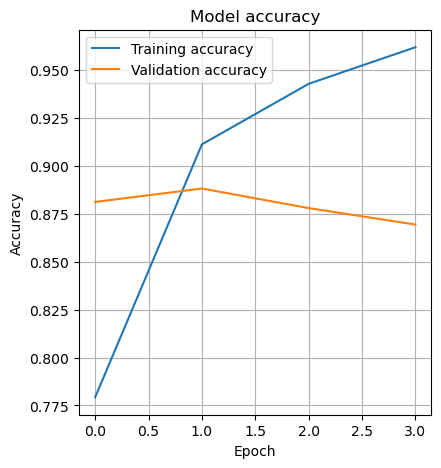

In [154]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()



### Attention mechanism metrics


In [155]:
inputs = att_model.input
embedding_output = att_model.layers[1](inputs)
att_output, att_scores = att_model.layers[2](embedding_output, embedding_output, embedding_output, return_attention_scores=True)
score_model = Model(inputs=inputs, outputs=[att_output, att_scores])

In [156]:
sample_input = x_train[:1]  # a single training example
_, attention_scores_all = score_model.predict(sample_input)

# scores for a single attention head
head_index = 1
attention_scores = attention_scores_all[0][head_index]

# Verify the shape of attention scores
print(f"Attention scores, full shape: {attention_scores_all.shape}")
print(f"Attention scores, one head: {attention_scores.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Attention scores, full shape: (1, 3, 250, 250)
Attention scores, one head: (250, 250)


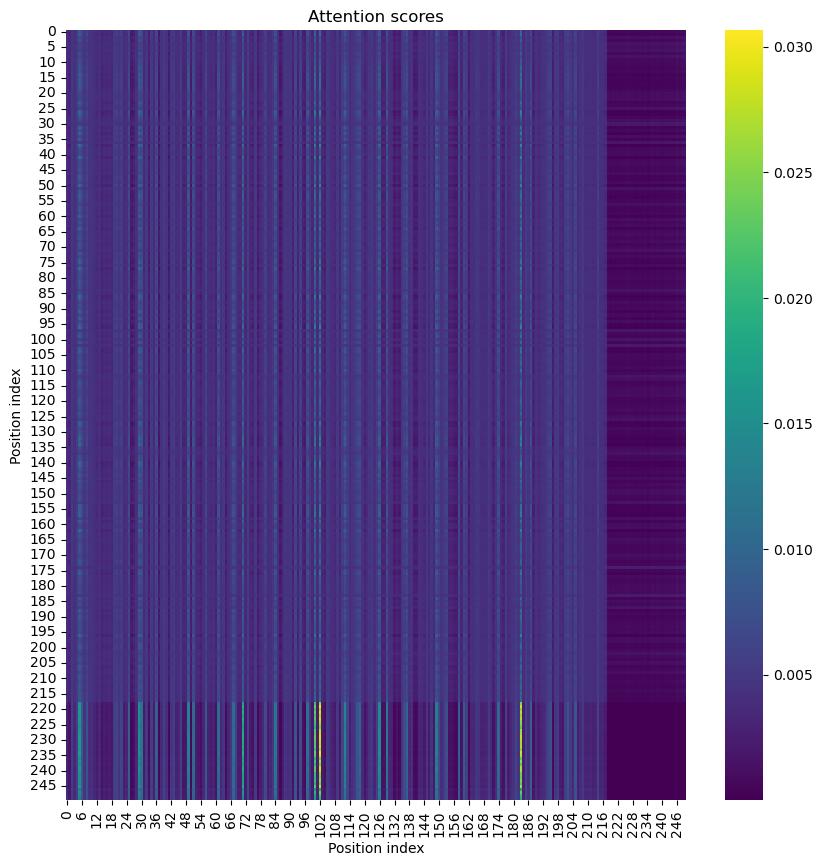

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(attention_scores, cmap='viridis')
plt.title('Attention scores')
plt.xlabel('Position index')
plt.ylabel('Position index')
plt.show()

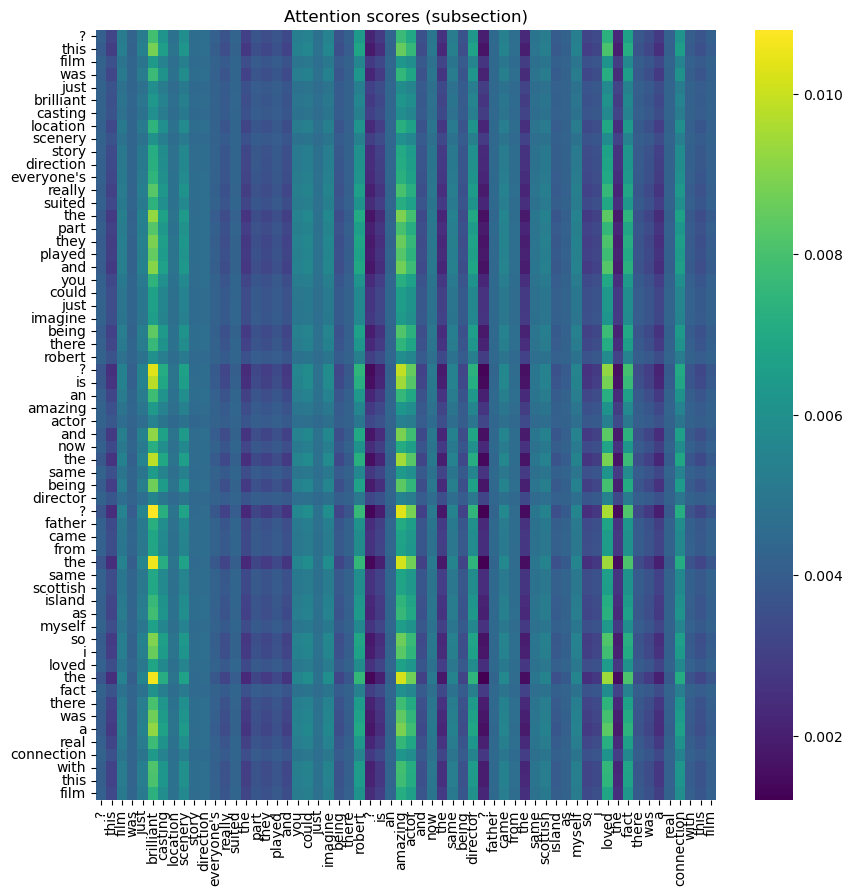

In [158]:
sub_length = 60  # Adjust the length of the subsection as needed
sub_scores = attention_scores[:sub_length, :sub_length]

# Plot the attention scores for the subsection
plt.figure(figsize=(10, 10))
sns.heatmap(sub_scores,
            cmap='viridis',
            xticklabels=[index_to_word.get(i - 3, '?') for i in sample_input[0][:sub_length]],
            yticklabels=[index_to_word.get(i - 3, '?') for i in sample_input[0][:sub_length]])
plt.title('Attention scores (subsection)')
plt.show()